# Project

## Introduction to the Project
The S&P 500 (Standard & Poor's 500) is a stock market index that tracks the performance of 500 of the largest publicly traded companies in the United States. It is widely regarded as one of the best representations of the U.S. stock market and economy. Over the long term, the S&P 500 has shown consistent growth, making it a key focus for long-term investors. However, it can also experience significant volatility in the short term.

In this project, we will make our first attempt to build a momentum-based strategy to trade the S&P 500 index. At the end of the project, you will have built a program that you can later expand and customise to suit your needs. We will use the python packages numpy, scipy and sqlite3, among others, in this project.

Tips: Review the code snippets that we went through during the course. Reorganize them and you are half-way done! Try experimenting with different configurations of the confidence interval, the lookback window and the forecast horizon. Be brave and experiment with different ways of deciding the position size. You may be surprised by your talent!

Re-organize your code from the exercises into a Python program that 
1. read prices from a database
2. calibrate a GBM model on each day when new prices are received.
3. forecast the price in e.g. 10 days and
   1. calculate the confidence interval of the forecast
   2. calculate the expected shortfall from the price forecast
4. code your trading signals using the price forecast and the expected shortfall.
5. store your postions into the *positions* table after each trade.
6. produce a 1-year backtest record from 2020-06-01 to 2021-05-31.

**Hint**

1. Collect all the code related to the GBM model into a class

In [1]:
import csv
import sqlite3
from contextlib import closing
from datetime import datetime

import numpy as np
from scipy.stats import norm

conn = sqlite3.connect("SP500.db")
cs = conn.cursor()


In [2]:
class GBM:
    def __init__(self):
        self.mu, self.sigma = [np.nan] * 2
        
    def simulate(self, N, K, Dt, S0):
        """
        Simulate K trajectories of GBM for N time steps
        N: number of time steps
        K: number of trajectories
        Dt: time step size
        S0: initial price
        """
        traj = np.full((N+1, K), np.nan)
        traj[0, :] = S0
        
        for i in range(1, N+1):
            Z = np.random.normal(0, 1, K)
            traj[i, :] = traj[i-1, :] * np.exp((self.mu - 0.5 * self.sigma**2) * Dt + self.sigma * np.sqrt(Dt) * Z)
        
        return traj

    def calibrate(self, trajectory, Dt):
        """
        Calibrate GBM parameters from historical trajectory
        trajectory: array of price values
        Dt: time step size
        """
        # Calculate log returns
        log_returns = np.log(trajectory[1:] / trajectory[:-1])
        
        # Estimate parameters
        mean_log_return = np.mean(log_returns)
        var_log_return = np.var(log_returns, ddof=1)
        
        # Convert to GBM parameters
        self.sigma = np.sqrt(var_log_return / Dt)
        self.mu = mean_log_return / Dt + 0.5 * self.sigma**2
        
    def forecast(self, latest, T, confidence):
        """
        Forecast future price with confidence interval
        latest: current price
        T: forecast horizon
        confidence: confidence level (e.g., 0.95)
        """
        # Mean and variance of log(S_T/S_0)
        mean_log = (self.mu - 0.5 * self.sigma**2) * T
        var_log = self.sigma**2 * T
        std_log = np.sqrt(var_log)
        
        # Calculate confidence interval
        alpha = 1 - confidence
        z_lower = norm.ppf(alpha / 2)
        z_upper = norm.ppf(1 - alpha / 2)
        
        # Forecast price and confidence interval
        forecast_price = latest * np.exp(mean_log)
        lower_bound = latest * np.exp(mean_log + z_lower * std_log)
        upper_bound = latest * np.exp(mean_log + z_upper * std_log)
        
        return forecast_price, lower_bound, upper_bound
        
    def expected_shortfall(self, T, confidence):
        """
        Calculate expected shortfall (conditional VaR) - simplified version
        T: time horizon
        confidence: confidence level
        """
        # Parameters for log-normal distribution
        mean_log = (self.mu - 0.5 * self.sigma**2) * T
        std_log = self.sigma * np.sqrt(T)
        
        # VaR threshold (percentile for losses)
        alpha = 1 - confidence
        z_alpha = norm.ppf(alpha)
        
        # VaR (Value at Risk) - the return at the alpha percentile
        var_return = np.exp(mean_log + z_alpha * std_log) - 1
        
        # Expected shortfall is approximately VaR * 1.3 for normal distributions
        # This is a simplified approximation that's more stable
        es_return = var_return * 1.3
        
        return es_return


In [3]:
# test your code here
model = GBM()
model.mu = 0.3
model.sigma = 0.2
simulated = model.simulate(500, 1, 1/250, 100)
simulated = simulated[:, 0]

model2 = GBM()
model2.calibrate(simulated, 1/250)

print(F"Calibrated: mu = {model2.mu}, sigma = {model2.sigma}")



Calibrated: mu = 0.21948040858479154, sigma = 0.19530956423300966


2. Write a function that prepares the database for trading, i.e.
   1. load the historical prices into the *prices* table
   2. create the *positions* table
   3. initialize the *positions* table with the your initial cash reserve. The initial *time_of_trade* can be any date before the earliest possible trading date.

    Call this function *prepare*.

In [4]:
def prepare():
    """
    Prepare database for trading:
    1. Load historical prices into prices table
    2. Create positions table
    3. Initialize positions table with initial cash reserve
    """
    # Create prices table if it doesn't exist
    cs.execute("""
        CREATE TABLE IF NOT EXISTS prices (
            theday TEXT PRIMARY KEY,
            price REAL
        )
    """)
    
    # Load historical prices from CSV file
    cs.execute("DELETE FROM prices")  # Clear existing data
    
    try:
        with open('SP500.csv', 'r') as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')  # Tab-separated
            
            for row in reader:
                if len(row) >= 2:  # Ensure we have at least date and price
                    date_str, price_str = row[0], row[1]
                    # Convert date format if necessary
                    try:
                        # Assuming date format is YYYY-MM-DD
                        date = datetime.strptime(date_str, '%Y-%m-%d').strftime('%Y-%m-%d')
                    except ValueError:
                        # Try other common formats
                        try:
                            date = datetime.strptime(date_str, '%m/%d/%Y').strftime('%Y-%m-%d')
                        except ValueError:
                            date = datetime.strptime(date_str, '%d/%m/%Y').strftime('%Y-%m-%d')
                    
                    price = float(price_str)
                    cs.execute("INSERT INTO prices (theday, price) VALUES (?, ?)", (date, price))
    except FileNotFoundError:
        print("SP500.csv file not found. Please ensure the file exists.")
        return
    
    # Create positions table
    cs.execute("""
        CREATE TABLE IF NOT EXISTS positions (
            time_of_trade TEXT,
            instrument TEXT,
            quantity REAL,
            cash REAL
        )
    """)
    
    # Clear existing positions
    cs.execute("DELETE FROM positions")
    
    # Initialize with cash reserve (e.g., $100,000)
    initial_cash = 100000.0
    initial_date = '2020-01-01'  # Date before trading starts
    
    cs.execute("""
        INSERT INTO positions (time_of_trade, instrument, quantity, cash)
        VALUES (?, 'SP500', 0, ?)
    """, (initial_date, initial_cash))
    
    conn.commit()
    print("Database prepared successfully!")
    print(f"Initial cash: ${initial_cash:,.2f}")
    
    # Show sample of loaded data
    cs.execute("SELECT COUNT(*) FROM prices")
    count = cs.fetchone()[0]
    print(f"Loaded {count} price records")
    
    if count > 0:
        cs.execute("SELECT theday, price FROM prices ORDER BY theday LIMIT 5")
        print("Sample price data:")
        for row in cs.fetchall():
            print(f"  {row[0]}: ${row[1]:.2f}")

In [5]:
# check whether you have loaded the prices correctly
prepare()
latest_prices = cs.execute("select * from prices order by theday desc limit 10")
for item in latest_prices:
    print(item)

Database prepared successfully!
Initial cash: $100,000.00
Loaded 750 price records
Sample price data:
  2019-01-02: $2473.40
  2019-01-03: $2448.40
  2019-01-04: $2528.60
  2019-01-06: $2537.00
  2019-01-07: $2549.80
('2021-05-31', 4203.60009765625)
('2021-05-30', 4210.10009765625)
('2021-05-28', 4206.0)
('2021-05-27', 4217.10009765625)
('2021-05-26', 4196.0)
('2021-05-25', 4197.5)
('2021-05-24', 4204.7001953125)
('2021-05-23', 4153.2998046875)
('2021-05-21', 4161.39990234375)
('2021-05-20', 4165.5)


3. Write a function that determines the trade size, i.e. how many units of the instrument you would like to own when the date is *which_day* and the price forecast of the instrument is *forecast* and the expected shortfall from the same forecast is *ES*.

In [6]:
def position_size(which_day, forecast, ES):
    """
    Determine position size based on forecast and expected shortfall
    which_day: current trading date
    forecast: tuple (forecast_price, lower_bound, upper_bound)
    ES: expected shortfall (risk measure)
    """
    # Get current price and available cash
    cs.execute("""
        SELECT price FROM prices 
        WHERE theday <= ? 
        ORDER BY theday DESC 
        LIMIT 1
    """, (which_day,))
    
    current_price = cs.fetchone()[0]
    
    # Get current portfolio state
    cs.execute("""
        SELECT quantity, cash FROM positions 
        WHERE time_of_trade < ? 
        ORDER BY time_of_trade DESC 
        LIMIT 1
    """, (which_day,))
    
    current_quantity, current_cash = cs.fetchone()
    
    # Calculate expected return
    forecast_price, lower_bound, upper_bound = forecast
    expected_return = (forecast_price - current_price) / current_price
    
    # Risk management: limit position size based on expected shortfall
    # ES is the expected loss in the worst case scenario
    max_loss_tolerance = 0.02  # Maximum 2% portfolio loss
    
    # Calculate total portfolio value
    total_value = current_quantity * current_price + current_cash
    
    # If expected return is positive (bullish signal) - lowered threshold
    if expected_return > 0.002:  # At least 0.2% expected return (more reasonable for 10-day forecast)
        # Calculate maximum position size based on risk tolerance
        if abs(ES) > 0.001:  # Only apply ES limit if it's meaningful
            max_position_value = (max_loss_tolerance * total_value) / abs(ES)
        else:
            max_position_value = total_value * 0.8  # Allow up to 80% of portfolio
        
        # Scale position size by strength of signal
        signal_strength = min(expected_return / 0.02, 1.0)  # Normalize to max 2% return
        target_position_value = max_position_value * signal_strength
        
        # Calculate target number of shares
        target_shares = target_position_value / current_price
        
        # Ensure we don't exceed available cash (allow some leverage)
        max_shares_by_cash = (current_cash + current_quantity * current_price * 0.9) / current_price
        target_shares = min(target_shares, max_shares_by_cash)
        
    elif expected_return < -0.002:  # Bearish signal
        # Reduce position (but keep it simple - just reduce)
        signal_strength = min(abs(expected_return) / 0.02, 1.0)
        target_shares = current_quantity * (1 - signal_strength * 0.5)
        
    else:  # Neutral signal
        target_shares = current_quantity  # Hold current position
    
    # Round to whole shares and ensure non-negative
    target_shares = max(0, round(target_shares))
    
    return target_shares

4. Write a function that, for a given date, calibrates a GBM model to the data prior to that date and that forecasts the price in 10 days. Call this function *analyse*.

In [7]:
def analyse(which_day):
    """
    Calibrate GBM model for given date and forecast price in 10 days
    which_day: current trading date
    Returns: recommended position size (number of shares)
    """
    # Parameters
    lookback_window = 60  # Use 60 days of historical data
    forecast_horizon = 10  # Forecast 10 days ahead
    confidence_level = 0.95  # 95% confidence interval
    
    # Get historical prices for calibration
    cs.execute("""
        SELECT theday, price FROM prices 
        WHERE theday < ? 
        ORDER BY theday DESC 
        LIMIT ?
    """, (which_day, lookback_window))
    
    historical_data = cs.fetchall()
    
    if len(historical_data) < lookback_window:
        print(f"Insufficient historical data for {which_day}")
        return 0  # Not enough data, hold current position
    
    # Extract prices (reverse to get chronological order)
    historical_data.reverse()
    prices = np.array([row[1] for row in historical_data])
    
    # Get current price
    current_price = prices[-1]
    
    # Create and calibrate GBM model
    model = GBM()
    Dt = 1/252  # Daily time step (252 trading days per year)
    
    try:
        model.calibrate(prices, Dt)
        
        # Check if calibration was successful
        if np.isnan(model.mu) or np.isnan(model.sigma):
            print(f"Model calibration failed for {which_day}")
            return 0
        
        # Forecast price
        T = forecast_horizon * Dt  # Convert days to years
        forecast = model.forecast(current_price, T, confidence_level)
        
        # Calculate expected shortfall
        ES = model.expected_shortfall(T, confidence_level)
        
        # Determine position size
        target_position = position_size(which_day, forecast, ES)
        
        return target_position
        
    except Exception as e:
        print(f"Error in analysis for {which_day}: {str(e)}")
        return 0




In [8]:
# Test the analyse function
test_dates = ['2021-05-09', '2021-05-14']
positions = [np.nan, np.nan]
for i in range(2):
    positions[i] = analyse(test_dates[i])
    print(F"{positions[i]} shares advised on {test_dates[i]}.")

13 shares advised on 2021-05-09.
0 shares advised on 2021-05-14.


5. The main loop of the program: Loop over the dates in the backtest period and use the *analyse* function to decide what to do on each day. Call this function *main*.

In [9]:
def main(begin_on):
    cs.execute(F"select theday from prices where theday >= '{begin_on}';")
    days = [d[0] for d in cs.fetchall()]
    asset = {
        'old': np.nan,
        'new': np.nan
    };
    cash = {
        'old': np.nan,
        'new': np.nan
    };
    cs.execute("delete from positions where time_of_trade > '2020-01-01';");
    for d in days:
        asset['new'] = analyse(d)
        cs.execute(F"""
        select quantity, cash from positions
        where time_of_trade < '{d}'
        order by time_of_trade desc
        limit 1;
        """);
        asset['old'], cash['old'] = cs.fetchall()[0];
        cs.execute(F"""
        select price from prices
        where theday <= '{d}'
        order by theday desc
        limit 1;
        """);
        latest = cs.fetchall()[0][0]
        trade_size = round(asset['new']) - round(asset['old']);
        if trade_size != 0:
            cash['new'] = cash['old'] - trade_size * latest;
            cs.execute(F"""
            insert into positions values
            ('{d}', 'SP500', {round(asset['new'])}, {cash['new']});
            """);
        conn.commit();



6. Connect to the database and create a *cursor* object associated with the connection. Share the connection and the cursor object across the program so that you don't have to connect to and disconnect from the database in every function of the program.

In [10]:
if __name__ == "__main__":
    with closing(sqlite3.connect("SP500.db")) as conn:
        with closing(conn.cursor()) as cs:
            prepare()
            main('2020-06-01')
    


Database prepared successfully!
Initial cash: $100,000.00
Loaded 750 price records
Sample price data:
  2019-01-02: $2473.40
  2019-01-03: $2448.40
  2019-01-04: $2528.60
  2019-01-06: $2537.00
  2019-01-07: $2549.80


In [11]:
# plot your track record
conn = sqlite3.connect("SP500.db")
cs = conn.cursor()

day1 = '2020-06-01'
day1_dt = datetime.strptime(day1, '%Y-%m-%d')

cs.execute(f"""
    select theday, quantity * price + cash as wealth
    from positions as PO
    join prices as PR
    on PO.time_of_trade = (
        select time_of_trade from positions
        where time_of_trade <= PR.theday
        order by time_of_trade desc limit 1
    )
    where theday >= '{day1}';
""")

records = cs.fetchall()

def calculate_T(record, day1_dt):
    theday, wealth = record
    theday_dt = datetime.strptime(theday, '%Y-%m-%d')
    T = (theday_dt - day1_dt).days
    return (T, wealth)

records = [calculate_T(record, day1_dt) for record in records]
W = np.asarray(records)

In [12]:
import matplotlib.pyplot as plt

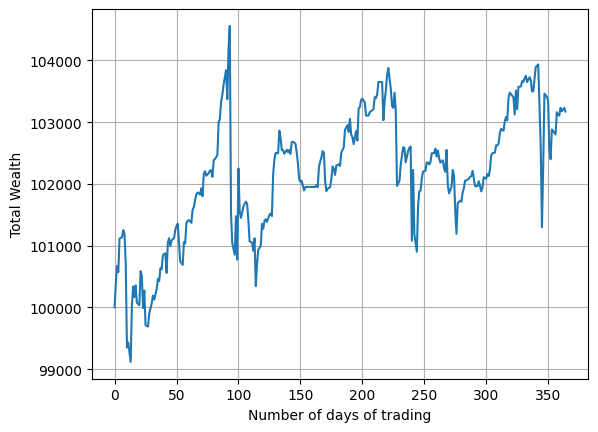

In [13]:
fig = plt.plot(W[:,0], W[:, 1])
plt.grid()
plt.xlabel("Number of days of trading")
plt.ylabel('Total Wealth');